# First Steps with Feedback Control

**WARNING:** Some cells in this notebook are not meant to be run sequentially!

In [327]:
import sys
sys.path.append('..')

In [328]:
%matplotlib inline  
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [329]:
from ctrl.block.linear import TransferFunction, Gain, Feedback
from ctrl.system.tf import PID, LPF
from ctrl.block.logger import Logger
from ctrl.block.nl import DeadZone

Substitute `HOST` and `PORT` with the IP address and port of your controller:

In [330]:
from ctrl.client import Controller
HOST, PORT = "192.168.10.102", 9999
controller = Controller(host = HOST, port = PORT)

#Closed loop on $\phi$ (Down)

In [10]:
fc = 10
Kp = 4*100

controller.reset()
controller.add_signals('reference1','deadzoneinverse','filter')
controller.add_sink('logger', Logger(), 
                    ['clock', 'encoder1','motor1','reference1','theta','filter'])
controller.add_filter('controller1',
                      Feedback(block = Gain(Kp)),
                      ['filter'], 
                      ['deadzoneinverse'])
controller.add_filter('filter', 
                      Feedback(block = TransferFunction(model = LPF(fc = fc, period = controller.period))),
                      ['encoder1', 'reference1'], 
                      ['deadzoneinverse'])
controller.add_filter('deadzoneinverse', 
                      DeadZone(Y = 11, X = 1),
                      ['deadzoneinverse'], 
                      ['motor1'])
print(controller.info('all'))

> Controller with 7 signal(s), 4 source(s), 2 sink(s), and 2 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. pot1
  4. motor1
  5. reference1
  6. theta
  7. deadzoneinverse
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. inclinometer1[enabled] >> theta
> filters
  1. encoder1, reference1 >> controller1[enabled] >> deadzoneinverse
  2. deadzoneinverse >> deadzoneinverse[enabled] >> motor1
> sinks
  1. motor1 >> motor1[enabled]
  2. clock, encoder1, motor1, reference1, theta >> logger[enabled]



In [7]:
controller.set_source('encoder1',reset=True)

In [18]:
preference = 0/360*100
controller.set_source('clock',reset=True)
controller.set_sink('logger',reset=True)
with controller:
    controller.set_signal('reference1',preference)
    time.sleep(10)
log = controller.read_sink('logger')

In [19]:
t = log[:,0]
position = log[:,1]
control = log[:,2]
reference = log[:,3]
theta = log[:,4]

print(np.mean(theta))

velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

-0.247968773783


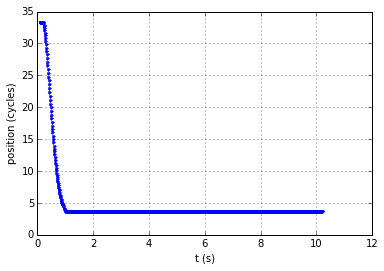

In [20]:
plt.plot(t, 360*position, '.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

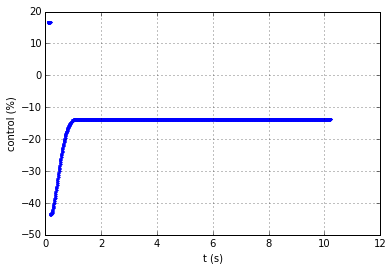

In [21]:
plt.plot(t, control, '.')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

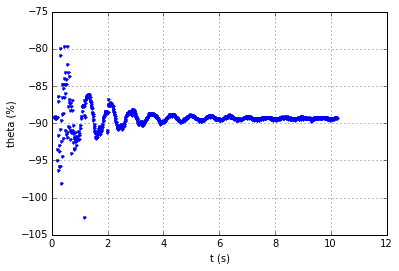

In [22]:
plt.plot(t, 360*theta, '.')
plt.xlabel('t (s)')
plt.ylabel('theta (%)')
plt.grid()

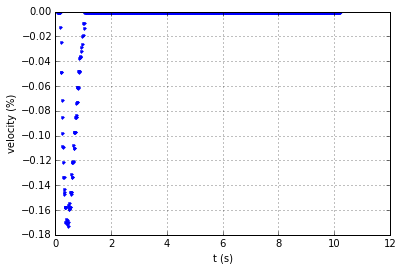

In [23]:
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (%)')
plt.grid()

#Closed loop on $\theta$ (Down)

In [61]:
# 2 pi needed to convert from cycles to rads
fc = 7
Kp = -2*math.pi*1*100
DZ = 20

controller.reset()
controller.add_signals('reference1','deadzoneinverse','filter')
controller.add_sink('logger', Logger(), 
                    ['clock', 'encoder1','deadzoneinverse','motor1','reference1','theta','filter'])

controller.add_filter('controller1',
                      Gain(Kp),
                      ['filter'], 
                      ['deadzoneinverse'])

controller.add_filter('filter', 
                      Feedback(block = TransferFunction(model = LPF(fc = fc, period = controller.period))),
                      ['theta', 'reference1'], 
                      ['filter'])

controller.add_filter('deadzoneinverse', 
                      DeadZone(Y = DZ, X = 1),
                      ['deadzoneinverse'], 
                      ['motor1'])

print(controller.info('all'))

> Controller with 8 signal(s), 4 source(s), 2 sink(s), and 3 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. pot1
  4. filter
  5. motor1
  6. reference1
  7. theta
  8. deadzoneinverse
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. inclinometer1[enabled] >> theta
> filters
  1. filter >> controller1[enabled] >> deadzoneinverse
  2. theta, reference1 >> filter[enabled] >> filter
  3. deadzoneinverse >> deadzoneinverse[enabled] >> motor1
> sinks
  1. motor1 >> motor1[enabled]
  2. clock, encoder1, deadzoneinverse, motor1, reference1, theta, filter >> logger[enabled]



In [62]:
controller.set_signal('reference1',-.25)
controller.set_source('clock',reset=True)
controller.set_sink('logger',reset=True)
with controller:
    time.sleep(10)
log = controller.read_sink('logger')

In [63]:
t = log[:,0]
position = log[:,1]
control = log[:,2]
dz = log[:,3]
reference = log[:,4]
theta = log[:,5]
ferror = log[:,6]

ctrl = dz.copy()
ind = np.where(dz > DZ)
ctrl[ind] = ctrl[ind] - DZ
ind = np.where(dz < -DZ)
ctrl[ind] = ctrl[ind] + DZ
ind = np.where((dz > -DZ) & (dz < DZ))
ctrl[ind] = 0

velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

(3.5, 5.5)

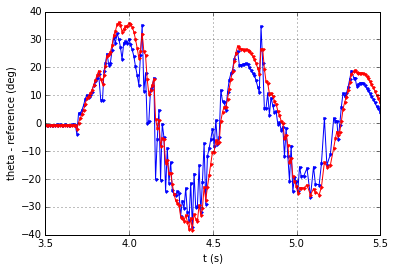

In [66]:
plt.plot(t, 360*(reference-theta), 'b.-', t, 360*ferror, 'r.-')
plt.xlabel('t (s)')
plt.ylabel('theta - reference (deg)')
plt.grid()
t0 = 3.5
plt.xlim(t0,t0+2)

(3, 5)

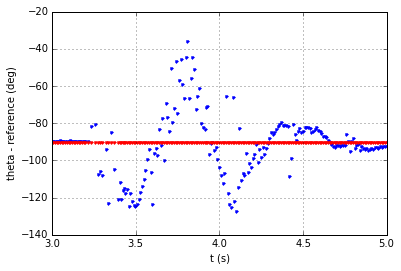

In [43]:
plt.plot(t, 360*theta, 'b.', t, 360*reference, 'r.')
plt.xlabel('t (s)')
plt.ylabel('theta - reference (deg)')
plt.grid()
plt.xlim(t0,t0+2)

(3, 5)

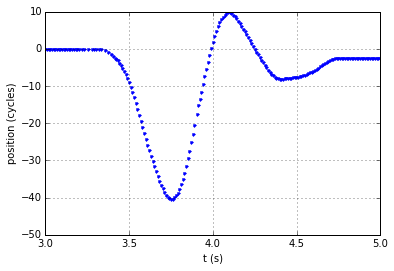

In [44]:
plt.plot(t, 360*position, '.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()
plt.xlim(t0,t0+2)

(1.5, 3.5)

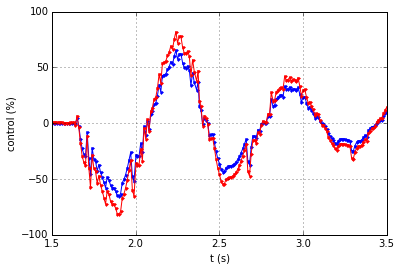

In [60]:
plt.plot(t, ctrl, 'b.-', t, control, 'r.-')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()
plt.xlim(t0,t0+2)

(0, 2)

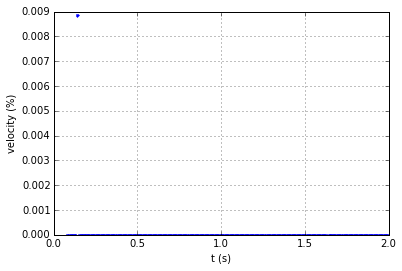

In [20]:
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (%)')
plt.grid()
plt.xlim(t0,t0+2)

#Calibrate inclinometer

In [317]:
controller.reset()
controller.add_sink('logger', Logger(), 
                    ['clock', 'theta'])
print(controller.info('all'))

> Controller with 5 signal(s), 4 source(s), 2 sink(s), and 0 filter(s)
> period = 0.01s
> signals
  1. theta
  2. encoder1
  3. pot1
  4. motor1
  5. clock
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. inclinometer1[enabled] >> theta
> filters
> sinks
  1. motor1 >> motor1[enabled]
  2. clock, theta >> logger[enabled]



In [318]:
controller.set_source('inclinometer1',reset=True)
with controller:
    time.sleep(10)
log = controller.read_sink('logger')

91.1612504903


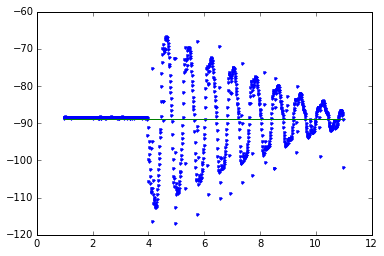

In [319]:
t = log[:,0]
theta = 360*log[:,1]

theta90 = 180+np.mean(theta)
print(theta90)

plt.plot(t, theta, '.', np.array([t[0],t[-1]]), (theta90-180) * np.array([1,1]))

#Control Up/Up

In [343]:
import ctrl.system.tf as tf

# numctr =
#  -555.5556  527.7917
# denctr =
#     1.0000   -0.9990
# numfltr =
#          0    0.0782    0.0635
# denfltr =
#     1.0000   -1.3951    0.5369

# controller
# 2 pi needed to convert from cycles to rads
num = 2*math.pi*np.flipud(np.array([-555.5556,  527.7917]))
den = np.flipud(np.array([1.0000,   -0.9990]))

# dead-zone
DZ = 15

# filter 
fnum = np.flipud(np.array([0,0.0782,0.0635]))
fden = np.flipud(np.array([1.0000,-1.3951,0.5369]))

controller.reset()
controller.add_signals('reference1','deadzoneinverse','filter')
controller.add_sink('logger', Logger(), 
                    ['clock', 'encoder1','deadzoneinverse','motor1','reference1','theta','filter'])

controller.add_filter('controller1',
                      TransferFunction(model = tf.zDTTF(num, den)),
                      ['filter'], 
                      ['deadzoneinverse'])

controller.add_filter('filter', 
                      Feedback(block = TransferFunction(model = tf.zDTTF(fnum, fden))),
                      ['theta', 'reference1'], 
                      ['filter'])

controller.add_filter('deadzoneinverse', 
                      DeadZone(Y = DZ, X = 1),
                      ['deadzoneinverse'], 
                      ['motor1'])
print(controller.info('all'))

> Controller with 8 signal(s), 4 source(s), 2 sink(s), and 3 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. pot1
  4. filter
  5. motor1
  6. reference1
  7. theta
  8. deadzoneinverse
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. inclinometer1[enabled] >> theta
> filters
  1. filter >> controller1[enabled] >> deadzoneinverse
  2. theta, reference1 >> filter[enabled] >> filter
  3. deadzoneinverse >> deadzoneinverse[enabled] >> motor1
> sinks
  1. motor1 >> motor1[enabled]
  2. clock, encoder1, deadzoneinverse, motor1, reference1, theta, filter >> logger[enabled]



In [344]:
ref = theta90/360
print('ref = {}'.format(ref))

ref = 0.2532256958064797


In [345]:
controller.set_signal('reference1',ref)
controller.set_filter('controller1',reset=True)
controller.set_source('clock',reset=True)
controller.set_source('inclinometer1',reset=True)
controller.set_sink('logger',reset=True)
with controller:
    time.sleep(1)
log = controller.read_sink('logger')

In [346]:
t = log[:,0]
position = log[:,1]
control = log[:,2]
dz = log[:,3]
reference = log[:,4]
theta = log[:,5]
ferror = log[:,6]

ctrl = dz.copy()
ind = np.where(dz > DZ)
ctrl[ind] = ctrl[ind] - DZ
ind = np.where(dz < -DZ)
ctrl[ind] = ctrl[ind] + DZ
ind = np.where((dz > -DZ) & (dz < DZ))
ctrl[ind] = 0

velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

(-30, 30)

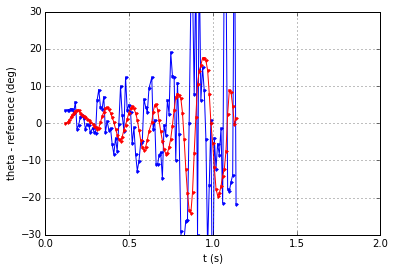

In [348]:
plt.plot(t, 360*(reference-theta), 'b.-', t, 360*ferror, 'r.-')
plt.xlabel('t (s)')
plt.ylabel('theta - reference (deg)')
plt.grid()
plt.xlim(0,2)
plt.ylim(-30,30)

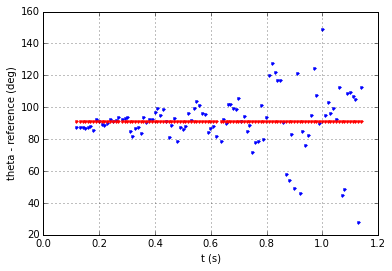

In [349]:
plt.plot(t, 360*theta, 'b.', t, 360*reference, 'r.')
plt.xlabel('t (s)')
plt.ylabel('theta - reference (deg)')
plt.grid()

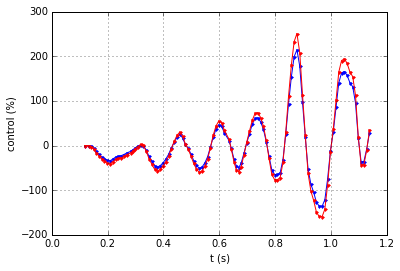

In [350]:
plt.plot(t, ctrl, 'b.-', t, control, 'r.-')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

In [15]:
pmax = 1
#Kp = 4*100

#12V Large Gear Box
#num = np.array([-80,76.84])
#den = np.array([1,-0.9975])

num = np.array([590.2778 -560.4668])
den = np.array([1,-3.244,3.94,-2.141,0.4454])

#num = np.array([0,-0.002084,0.002114,0.002024,-0.002054])
#den = np.array([1,-4,5.957,-3.914,0.9571])




try:
    controller.remove_filter('controller1')
except:
    pass
controller.add_filter('controller1', 
                      Feedback(gamma = pmax,
                               block = TransferFunction(model = TFModel(num, den))),
                      ['theta', 'reference1'], 
                      ['deadzoneinverse'])
print(controller.info('all'))

> Controller with 7 signal(s), 4 source(s), 2 sink(s), and 2 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. pot1
  4. motor1
  5. reference1
  6. theta
  7. deadzoneinverse
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. theta[enabled] >> theta
> filters
  1. deadzoneinverse >> deadzoneinverse[enabled] >> motor1
  2. theta, reference1 >> controller1[enabled] >> deadzoneinverse
> sinks
  1. motor1 >> motor1[disabled]
  2. clock, encoder1, motor1, reference1, theta >> logger[enabled]



#TRASH

In [16]:
preference = 0.5*100
controller.set_sink('logger','reset')
#controller.write_source('encoder1',[0,])
with controller:
    controller.set_signal('reference1',preference)
    time.sleep(5)
log = controller.read_sink('logger')


In [26]:
t = log[:,0]
position = log[:,1]
control = log[:,2]
reference = log[:,3]
theta = log[:,4]

print(np.mean(theta))

velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

0.497464642013


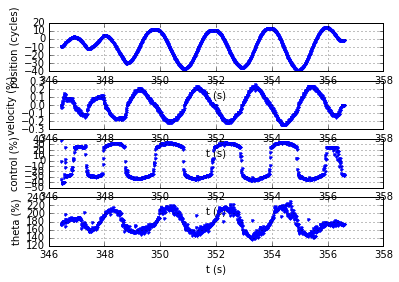

In [27]:
plt.subplot(4,1,1)
plt.plot(t, 360*position, '.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

plt.subplot(4,1,2)
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (%)')
plt.grid()

plt.subplot(4,1,3)
plt.plot(t, control, '.')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

plt.subplot(4,1,4)
plt.plot(t, 360*theta, '.')
plt.xlabel('t (s)')
plt.ylabel('theta (%)')
plt.grid()

#Control Up PID

In [23]:
pmax = 1
Kp = 3*100
Kd = 0.02*100
Ki = 0*100


try:
    controller.remove_filter('controller1')
except:
    pass
controller.add_filter('controller1', 
                      Feedback(gamma = pmax,
                               block = TransferFunction(model = PID(Kp = Kp, Kd = Kd, Ki = Ki, period = controller.period))),
                      ['theta', 'reference1'], 
                      ['deadzoneinverse'])
print(controller.info('all'))

> Controller with 7 signal(s), 4 source(s), 2 sink(s), and 2 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. pot1
  4. motor1
  5. reference1
  6. theta
  7. deadzoneinverse
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. pot1[enabled] >> pot1
  4. theta[enabled] >> theta
> filters
  1. deadzoneinverse >> deadzoneinverse[enabled] >> motor1
  2. theta, reference1 >> controller1[enabled] >> deadzoneinverse
> sinks
  1. motor1 >> motor1[disabled]
  2. clock, encoder1, motor1, reference1, theta >> logger[enabled]



In [24]:
preference = 0.75*100
controller.set_sink('logger','reset')
#controller.write_source('encoder1',[0,])
with controller:
    controller.set_signal('reference1',preference)
    time.sleep(5)
log = controller.read_sink('logger')

In [22]:
t = log[:,0]
position = log[:,1]
control = log[:,2]
reference = log[:,3]
theta = log[:,4]

print(np.mean(theta))

velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

0.755156296678


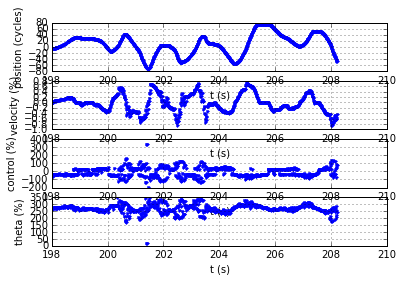

In [23]:
plt.subplot(4,1,1)
plt.plot(t, 360*position, '.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

plt.subplot(4,1,2)
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (%)')
plt.grid()

plt.subplot(4,1,3)
plt.plot(t, control, '.')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

plt.subplot(4,1,4)
plt.plot(t, 360*theta, '.')
plt.xlabel('t (s)')
plt.ylabel('theta (%)')
plt.grid()

In [9]:
control2 = control.copy()
ind = np.where((control2 > -umin) & (control2 < umin))
print(ind[0].shape, control2.shape)
control2[ind] = 0
ind = np.where(control2 > umin)
control2[ind] = control2[ind] - umin
ind = np.where(control < -umin)
control2[ind] = control2[ind] + umin

In [11]:
plt.plot(t, control2, 'b.', t, 100*position, 'r.')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()
plt.xlim(2,7)

a = 0.019, v0 = 16.613
